In [2]:
### Gene usage analysis ###

# Quantifying the VDJ gene based on either sequence count or clonotypes.
# options are based on "gene", "allele", "family"
# duplicate count does not work... missing the column. 

# Load required packages
library(alakazam)
library(dplyr)
library(scales)
library(ggplot2)

db <- readChangeoDb("vac_docker/changeo_10x/vac_heavy_germ-pass.tsv", drop = NULL, seq_upper = TRUE)
glimpse(db)


Rows: 3,060
Columns: 62
$ sequence_id               <chr> "ACGATACTCAACGCTA-1_contig_2", "TGGCCAGTCTC…
$ sequence                  <chr> "ACTGTTCTCTTTACAGTTACTGAGCACACAGGACCTCACCAT…
$ rev_comp                  <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F…
$ productive                <lgl> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, T…
$ v_call                    <chr> "IGHV1-72*01", "IGHV1-62-2*01,IGHV1-71*01",…
$ d_call                    <chr> "IGHD1-1*01", NA, "IGHD2-1*01,IGHD2-13*01,I…
$ j_call                    <chr> "IGHJ4*01", "IGHJ4*01", "IGHJ2*01", "IGHJ4*…
$ sequence_alignment        <chr> "CAGGTCCAACTGCAGCAGCCTGGGGCT...GAGCTTGTGAAG…
$ germline_alignment        <chr> "CAGGTCCAACTGCAGCAGCCTGGGGCT...GAGCTTGTGAAG…
$ junction                  <chr> "TGTGCAAGATTAGGGGGCTACGGTAATGCTATGGACTACTGG…
$ junction_aa               <chr> "CARLGGYGNAMDYW", "CARHEEDYYAMDYW", "CTRDST…
$ v_cigar                   <chr> "97S294=", "112S302=", "117S294=", "72S299=…
$ d_cigar                   

In [7]:
# Quantify usage at the gene level.
# Printing the first 4 genes.
gene <- countGenes(db, gene="v_call", mode="gene")
head(gene, n=4)

gene,seq_count,seq_freq
<chr>,<int>,<dbl>
IGHV1-26,185,0.06045752
IGHV3-6,119,0.03888889
IGHV1-64,110,0.03594771
IGHV1-55,100,0.03267974


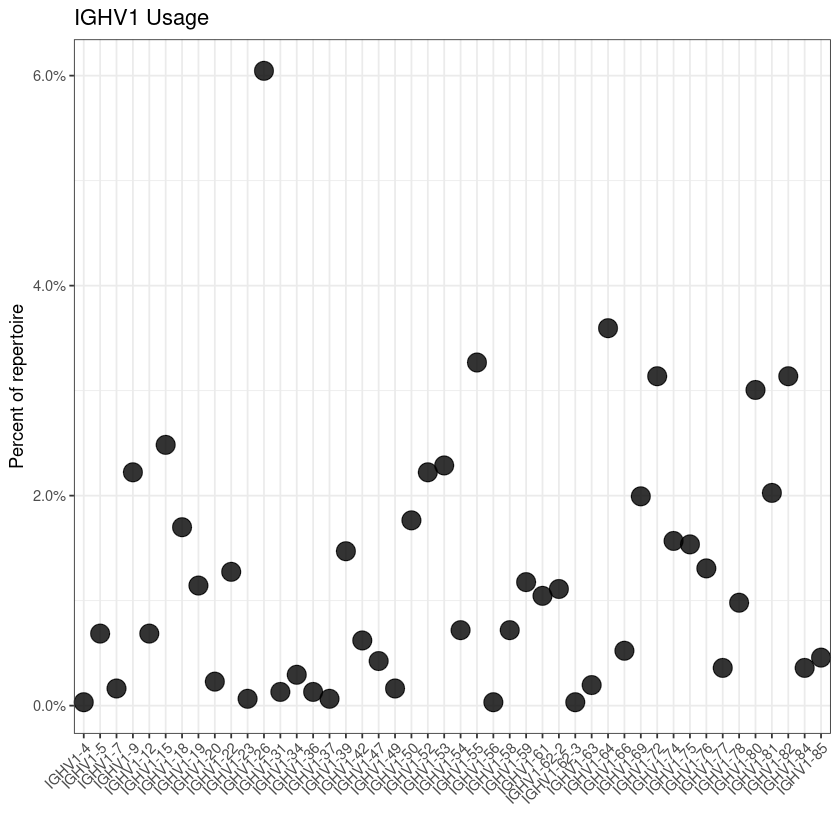

In [23]:
# Assign sorted levels and subset to IGHV1
ighv1 <- gene %>%
    mutate(gene=factor(gene, levels=sortGenes(unique(gene), method="name"))) %>%
    filter(getFamily(gene) == "IGHV1")

# Plot V gene usage in the IGHV1 family by sample
g1 <- ggplot(ighv1, aes(x=gene, y=seq_freq)) +
    theme_bw() +
    ggtitle("IGHV1 Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +
    xlab("") +
    scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set1") +
    geom_point(aes(color=), size=5, alpha=0.8)
plot(g1)

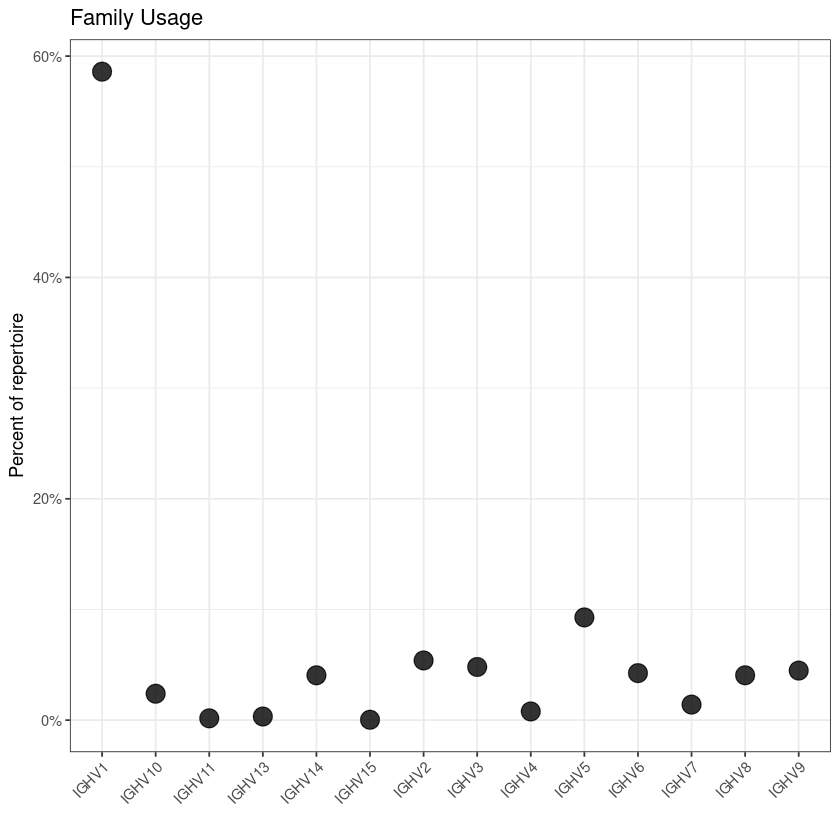

In [26]:
# Alternatively, quantify V gene based on the family.
family_v1 <- countGenes(db, gene="v_call", mode="family")

# Plot V family usage by sample
g2 <- ggplot(family_v1, aes(x=gene, y=seq_freq)) +
    theme_bw() +
    ggtitle("Family Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +
    xlab("") +
    scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set1") +
    geom_point(size=5, alpha=0.8)
plot(g2)

In [27]:
# Grouping multiple columns to calculate abundance.
# Clonal criteria is added to display the most common allele/gene/family.

# Quantify V family clonal usage by sample and C isotype
family_v_c_group <- countGenes(db, gene="v_call", groups=c("c_call"), 
                     clone="clone_id", mode="family")
head(family_v_c_group, n=4)

c_call,gene,clone_count,clone_freq
<chr>,<chr>,<int>,<dbl>
IGHA,IGHV10,1,0.026315789
IGHD,IGHV4,1,0.002583979
IGHD,IGHV7,1,0.002583979
IGHG1,IGHV1,1,0.200000000


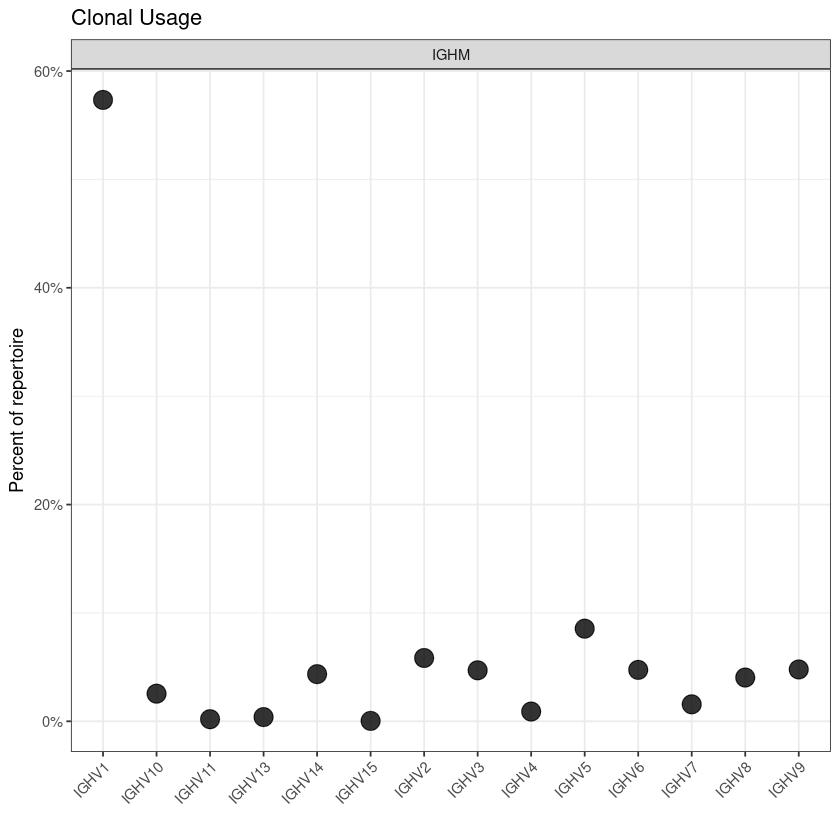

In [28]:
# Subset to IGHM and IGHG for plotting
family_v_c_group <- filter(family, c_call %in% c("IGHM", "IGHG"))
# Plot V family clonal usage by sample and isotype
g3 <- ggplot(family_v_c_group, aes(x=gene, y=clone_freq)) +
    theme_bw() +
    ggtitle("Clonal Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +
    xlab("") +
    scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set1") +
    geom_point(size=5, alpha=0.8) +
    facet_grid(. ~ c_call)
plot(g3)

In [30]:
# Alternatively, quantify V family clonal usage by sample and C isotype
# using copy number for the individual sequences. NOT using the clonotype counts.

family_dupli <- countGenes(db, gene="v_call", groups=c("c_call"), 
                     mode="family", copy="duplicate_count")
head(family_dupli, n=4)

Warning message in countGenes(db, gene = "v_call", groups = c("c_call"), mode = "family", :
“The column duplicate_count was not found”


ERROR: Error: Problem with `summarise()` input `copy_count`.
[31m✖[39m object 'duplicate_count' not found
[34mℹ[39m Input `copy_count` is `sum(duplicate_count, na.rm = TRUE)`.
[34mℹ[39m The error occurred in group 1: c_call = "IGHA", v_call = "IGHV1".


In [33]:
# Summary

# 1. Without copy numbers
genes_clone_family <- countGenes(db, gene="v_call", mode="family")
genes_gene <- countGenes(db, gene="v_call", mode="gene")
genes_allele <- countGenes(db, gene="v_call", mode="allele")

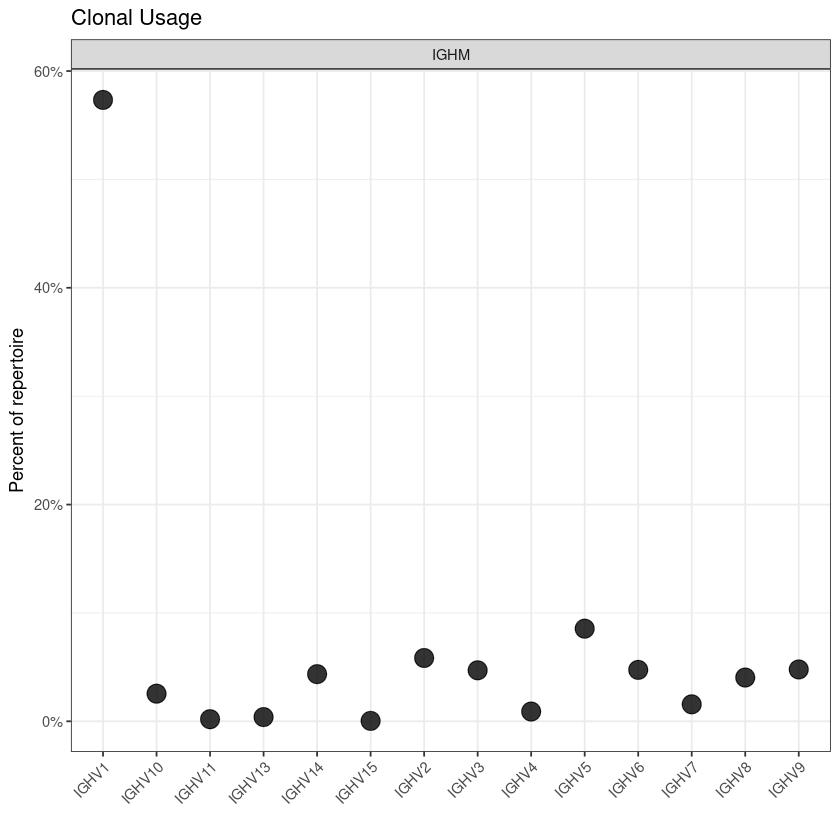

In [38]:
#2. With copy numbers based on clone
genes_clone_family <- countGenes(db, gene="v_call", groups = c("c_call"), clone = "clone_id", mode="family")

genes_clone_family <- filter(genes_clone_family, c_call %in% c("IGHM", "IGHG"))

g_clone_family <- ggplot(genes_clone_family, aes(x=gene, y=clone_freq)) +
    theme_bw() +
    ggtitle("Clonal Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +
    xlab("") +
    scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set1") +
    geom_point(size=5, alpha=0.8) +
    facet_grid(. ~ c_call)
plot(g_clone_family)


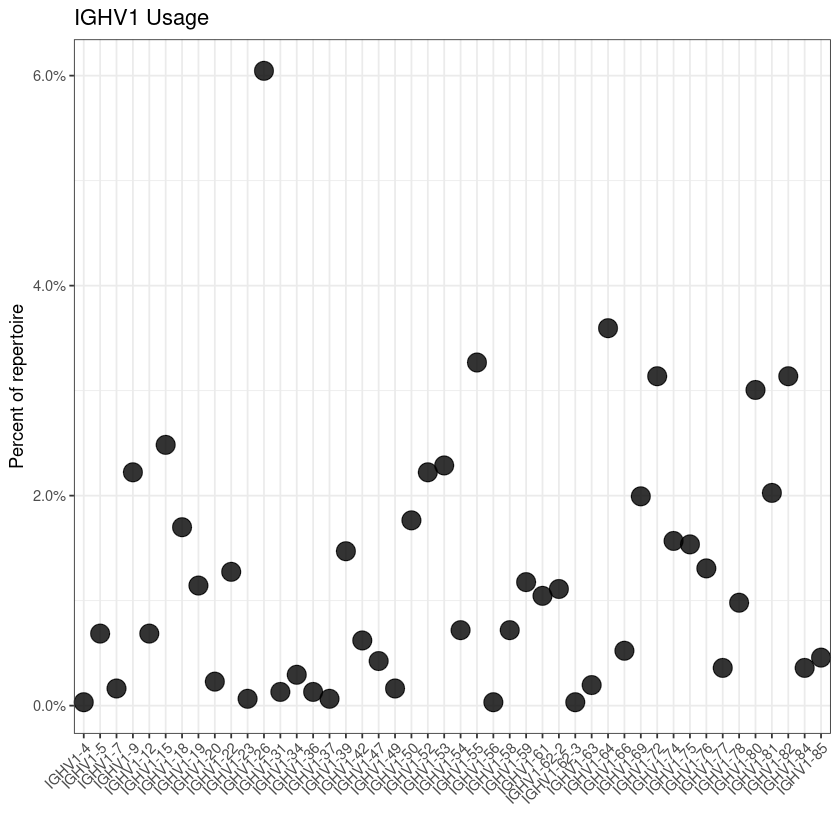

In [42]:
# 2. With copy numbers counting absent genes

gene_allele <- countGenes(db, gene="v_call", mode="allele")

# Assign sorted levels and subset to IGHV1
ighv1_allele <- gene %>%
    mutate(gene=factor(gene, levels=sortGenes(unique(gene), method="name"))) %>%
    filter(getFamily(gene) == "IGHV1")

# Plot V gene usage in the IGHV1 family by sample
g1_allele <- ggplot(ighv1_allele, aes(x=gene, y=seq_freq)) +
    theme_bw() +
    ggtitle("IGHV1 Usage") +
    theme(axis.text.x=element_text(angle=45, hjust=1, vjust=1)) +
    ylab("Percent of repertoire") +
    xlab("") +
    scale_y_continuous(labels=percent) +
    scale_color_brewer(palette="Set1") +
    geom_point(aes(color=), size=5, alpha=0.8)
plot(g1_allele)